### Multiple Model Accuracy comparison

In order to compare the accuracy of several rounds of training I have been using a plotting script for each round. 

This notebook is going and analyze the accuracy metrics   `per_position/per_position_data_0.5.csv` produced by several rounds of  `plot_multiple_variant_accuracy.py`. 


In [110]:
import os
from py3helpers.utils import list_dir
from signalalign.hiddenMarkovModel import HmmModel
from signalalign.visualization.plot_em_model_distributions import get_covered_bases
from scipy.stats import norm, invgauss, entropy
from scipy.spatial.distance import euclidean
from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from collections import defaultdict
def get_first_int(string):
    return int(re.search(r'\d+', string).group())

def read_in_mod_data():
    mods = "/Users/andrewbailey/CLionProjects/rrna_analysis/mod_files/corrected/mod_file.csv"
    mods_df = pd.read_csv(mods)
    mods_df["reference_index"] = mods_df["pos"] - 1
    return mods_df


reference = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/yeast_25S_18S.fa"
positions = "/Users/andrewbailey/CLionProjects/rrna_analysis/mod_files/corrected/yeast_18S_25S_mods_v2.positions"

def get_covered_bases_dict(reference, positions, kmer_length=5, rna=True):
    covered_bases_dict = defaultdict(defaultdict)
    covered_bases = get_covered_bases(reference, positions, kmer_length=5, rna=True)
    for ref, positions, variant, kmers in covered_bases:
        for pos in positions:
            covered_bases_dict[ref][pos] = kmers
    return covered_bases_dict

covered_bases_dict = get_covered_bases_dict(reference, positions, kmer_length=5, rna=True)





In [129]:
# Index(['contig', 'reference_index', 'strand', 'variants', 'accuracy',
#        'precision', 'negative_predictive_value', 'recall', 'specificity',
#        'positive_likelihood_ratio', 'negative_likelihood_ratio',
#        'diagnostic_odds_ratio', 'f1_score', 'prevalence', 'aucroc',
#        'avg_precision', 'brier_score'],
#       dtype='object')

def get_accuracy_df(dir_path):
    csvs = list_dir(dir_path, "csv")

    plot_me = defaultdict(defaultdict)
    for x in csvs:
        assert(os.path.exists(x))
        round_data = pd.read_csv(x)
        round_number = get_first_int(os.path.basename(x))
    #     print(round_number)
        for group, data in round_data.groupby(["contig", "reference_index", "strand"]):
            mod = "_".join([str(x) for x in group])
    #         print(data.accuracy.iloc[0])
            plot_me[mod][round_number] = data.accuracy.iloc[0]
    data_frame = pd.DataFrame.from_dict(plot_me).T
    return data_frame

def preprocess_accuracy_csv(path, mod_data):
    assert(os.path.exists(path))
    accuracy_csv = pd.read_csv(path).sort_values(by=['contig', 'reference_index'])


    accuracy_csv['delta1'] = accuracy_csv.reference_index.diff().shift(-1)
    accuracy_csv['delta2'] = accuracy_csv.reference_index.diff().shift(0)
    accuracy_csv['delta'] = accuracy_csv[["delta1", "delta2"]].min(axis=1)
    accuracy_csv["in_2prime"] = (((accuracy_csv.variants.shift().isin(["Aa", "Cb", "Gc", "Td", "Tdm"]) & 
                                      (accuracy_csv.delta2 <= 5)) | 
                                     (accuracy_csv.variants.shift(-1).isin(["Aa", "Cb", "Gc", "Td", "Tdm"]) & 
                                      (accuracy_csv.delta1 <= 5))) & (~accuracy_csv.variants.isin(["Aa", "Cb", "Gc", "Td"])))  
    accuracy_csv["in_pseudo"] = (((accuracy_csv.variants.shift().isin(["Tl"]) & 
                                       (accuracy_csv.delta2 <= 5)) | 
                                      (accuracy_csv.variants.shift(-1).isin(["Tl", "Tdm"]) & 
                                       (accuracy_csv.delta1 <= 5))) & 
                                     (~accuracy_csv.variants.isin(["Tl"]))) 
    accuracy_csv["in_unknown"] = (accuracy_csv["in_pseudo"] | accuracy_csv["in_2prime"])
    mod_data = mod_data[["contig", "reference_index", "percent"]]
    accuracy_csv = pd.merge(accuracy_csv, mod_data, on=["contig", "reference_index"])
    return accuracy_csv

def plot_accuracy_over_time(directory, high_percent=100, low_percent=0, low_delta=0, high_delta=np.inf, key="accuracy"):
    """Plot accuracy over em round"""
    mod_data = read_in_mod_data()
    csvs = list_dir(dir_path, "csv")

    plot_me = defaultdict(defaultdict)
    for x in csvs:
        assert(os.path.exists(x))
        round_data = preprocess_accuracy_csv(x, mod_data)
        round_number = get_first_int(os.path.basename(x))
    #     print(round_number)
        for group, data in round_data.groupby(["contig", "reference_index", "strand"]):
            mod = "_".join([str(x) for x in group])
            if (data["percent"].iloc[0] < high_percent and 
                data["percent"].iloc[0] > low_percent and
                data["delta"].iloc[0] > low_delta and
                data["delta"].iloc[0] < high_delta):
                plot_me[mod][round_number] = data[key].iloc[0]

    fig = plt.figure(figsize=[10, 15])
    panel1 = plt.axes([0.1, 0.5, .6, .4])
    panel1.set_title('{} over training runs'.format(key))
    # panel1.set_xlim(0)
    # panel1.set_ylim(0)

    panel1.set_xlabel('Training Round')
    panel1.set_ylabel(key)

    lines = []
    for label, data_dict in plot_me.items():
        sorted_items = sorted(data_dict.items())
        l, = panel1.plot([x[0] for x in sorted_items], [x[1] for x in sorted_items], label=label)
        lines.append(l)

    panel1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=4)
    annot = panel1.annotate("", xy=(0, 0), xytext=(20, 20), textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(line, idx):
        posx, posy = [line.get_xdata()[idx], line.get_ydata()[idx]]
        annot.xy = (posx, posy)
        text = f'{line.get_label()}: {posx:.2f}-{posy:.2f}'
        annot.set_text(text)
        # annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
        annot.get_bbox_patch().set_alpha(0.4)


    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == panel1:
            for line in lines:
                cont, ind = line.contains(event)
                if cont:
                    update_annot(line, ind['ind'][0])
                    annot.set_visible(True)
                    fig.canvas.draw_idle()
                else:
                    if vis:
                        annot.set_visible(False)
                        fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

    return plt, list(plot_me.keys())


def get_kmer_kl_divergence(model, kmer1, kmer2):
    """Get Kullback–Leibler divergence between the HDP and ONT models for a specific kmer"""
    normal_mean1, normal_sd1 = model.get_event_mean_gaussian_parameters(kmer1)
    normal_mean2, normal_sd2 = model.get_event_mean_gaussian_parameters(kmer2)

    ont_normal_dist1 = norm.pdf(model.linspace, normal_mean1, normal_sd1)
    ont_normal_dist2 = norm.pdf(model.linspace, normal_mean2, normal_sd2)

    kl_divergence = entropy(pk=ont_normal_dist2, qk=ont_normal_dist1, base=2)

    return kl_divergence

def get_kmer_mean_delta(model, kmer1, kmer2):
    """Get Kullback–Leibler divergence between the HDP and ONT models for a specific kmer"""
    normal_mean1, normal_sd1 = model.get_event_mean_gaussian_parameters(kmer1)
    normal_mean2, normal_sd2 = model.get_event_mean_gaussian_parameters(kmer2)

    return np.abs(normal_mean1 - normal_mean2)

def plot_accuracy_vs_delta(csv_path, model, high_percent=100, low_percent=0, low_delta=0, high_delta=np.inf, key="accuracy", max_delta=False):
    """Plot accuracy vs model delta from canonical"""
    plot_me = defaultdict(list)
    assert(os.path.exists(csv_path))
    round_data = preprocess_accuracy_csv(csv_path, mod_data)
    round_number = get_first_int(os.path.basename(csv_path))
    #     print(round_number)
    for group, data in round_data.groupby(["contig", "reference_index", "strand"]):
        mod = "_".join([str(x) for x in group])
        if (data["percent"].iloc[0] < high_percent and 
            data["percent"].iloc[0] > low_percent and
            data["delta"].iloc[0] > low_delta and
            data["delta"].iloc[0] < high_delta):
            kmer_pairs = covered_bases_dict[group[0]][group[1]]
            deltas = []
            for kmer_pair in kmer_pairs:
                kmer_pair = list(kmer_pair)
                if len(kmer_pair) > 2:
                    subset_kmer_deltas = []
                    subset_kmer_pairs = list(combinations(kmer_pair, 2))
                    for k1, k2 in subset_kmer_pairs:
                        subset_kmer_deltas.append(get_kmer_mean_delta(model, k1, k2))
                    deltas.append(max(subset_kmer_deltas))
                else:
                    deltas.append(get_kmer_mean_delta(model, kmer_pair[0], kmer_pair[1]))
            if max_delta:
                delta=max(deltas)
            else:
                delta=sum(deltas)
            plot_me[mod] = [data[key].iloc[0], delta]

    fig = plt.figure(figsize=[10, 15])
    panel1 = plt.axes([0.1, 0.5, .6, .4])
    if max_delta:
        panel1.set_title(f'{key} vs Max delta between modified and canonical')
        panel1.set_xlabel("Max delta between modified and canonical")
    else:
        panel1.set_title(f'{key} vs Sum deltas between modified and canonical')
        panel1.set_xlabel("Sum deltas between modified and canonical")

    panel1.set_ylabel(key)

    lines = []
    accuracy_values = []
    delta_values = []
    for label, (acc, delta) in plot_me.items():
        accuracy_values.append(acc)
        delta_values.append(delta)
        l, = panel1.plot(delta, acc, 'o', label=label)
        lines.append(l)
        
    m, b = np.polyfit(delta_values, accuracy_values, 1)
    panel1.plot(delta_values, m*np.array(delta_values) + b, label=f"slope={round(m, 4)} : intercept={round(b, 4)}")

    panel1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=4)
    annot = panel1.annotate("", xy=(0, 0), xytext=(20, 20), textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(line, idx):
        posx, posy = [line.get_xdata()[idx], line.get_ydata()[idx]]
        annot.xy = (posx, posy)
        text = f'{line.get_label()}: {posx:.2f}-{posy:.2f}'
        annot.set_text(text)
        # annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
        annot.get_bbox_patch().set_alpha(0.4)


    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == panel1:
            for line in lines:
                cont, ind = line.contains(event)
                if cont:
                    update_annot(line, ind['ind'][0])
                    annot.set_visible(True)
                    fig.canvas.draw_idle()
                else:
                    if vis:
                        annot.set_visible(False)
                        fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

    return plt, list(plot_me.keys())


def plot_accuracy_vs_delta_and_accuracy_over_time(directory, model_dir, model_n, high_percent=100, low_percent=0, low_delta=0, high_delta=np.inf, key="accuracy", max_delta=False):
    """Plot accuracy vs model delta from canonical"""
    mod_data = read_in_mod_data()
    csvs = list_dir(dir_path, "csv")
    models = list_dir(model_dir, "model")
    assert len(csvs) == len(models), f"len(csvs) != len(models): {len(csvs)} != {len(models)}"
    plot_me2 = defaultdict(list)

    plot_me = defaultdict(defaultdict)
    for i, (x, model_path) in enumerate(zip(csvs, models)):
        assert(os.path.exists(x))
        round_data = preprocess_accuracy_csv(x, mod_data)
        round_number = get_first_int(os.path.basename(x))
    #     print(round_number)
        if i == model_n:
            model=HmmModel(model_path, rna=True)
        for group, data in round_data.groupby(["contig", "reference_index", "strand"]):
            mod = "_".join([str(x) for x in group])
            if (data["percent"].iloc[0] < high_percent and 
                data["percent"].iloc[0] > low_percent and
                data["delta"].iloc[0] > low_delta and
                data["delta"].iloc[0] < high_delta):
                plot_me[mod][round_number] = data[key].iloc[0]
                # other plot
                if i == model_n:
                    kmer_pairs = covered_bases_dict[group[0]][group[1]]
                    deltas = []
                    for kmer_pair in kmer_pairs:
                        kmer_pair = list(kmer_pair)
                        if len(kmer_pair) > 2:
                            subset_kmer_deltas = []
                            subset_kmer_pairs = list(combinations(kmer_pair, 2))
                            for k1, k2 in subset_kmer_pairs:
                                subset_kmer_deltas.append(get_kmer_mean_delta(model, k1, k2))
                            deltas.append(max(subset_kmer_deltas))
                        else:
                            deltas.append(get_kmer_mean_delta(model, kmer_pair[0], kmer_pair[1]))
                    if max_delta:
                        delta=max(deltas)
                    else:
                        delta=sum(deltas)
                    plot_me2[mod] = [data[key].iloc[0], delta]

    plt, keys = plot_fig_1(plot_me, key)
    plt, keys = plot_me_fig2(plot_me2, key, max_delta)
    return plt, keys

def plot_fig_1(plot_me, key):
#     fig 1
    fig = plt.figure(figsize=[10, 15])
    panel1 = plt.axes([0.1, 0.5, .6, .4])
    panel1.set_title('{} over training runs'.format(key))
    panel1.set_xlabel('Training Round')
    panel1.set_ylabel(key)

    lines = []
    for label, data_dict in plot_me.items():
        sorted_items = sorted(data_dict.items())
        l, = panel1.plot([x[0] for x in sorted_items], [x[1] for x in sorted_items], label=label)
        lines.append(l)

    panel1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=4)
    annot = panel1.annotate("", xy=(0, 0), xytext=(20, 20), textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(line, idx):
        posx, posy = [line.get_xdata()[idx], line.get_ydata()[idx]]
        annot.xy = (posx, posy)
        text = f'{line.get_label()}: {posx:.2f}-{posy:.2f}'
        annot.set_text(text)
        # annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
        annot.get_bbox_patch().set_alpha(0.4)


    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == panel1:
            for line in lines:
                cont, ind = line.contains(event)
                if cont:
                    update_annot(line, ind['ind'][0])
                    annot.set_visible(True)
                    fig.canvas.draw_idle()
                else:
                    if vis:
                        annot.set_visible(False)
                        fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)
    return plt, list(plot_me.keys())

   
def plot_me_fig2(plot_me, key, max_delta):
    fig = plt.figure(figsize=[10, 15])
    panel1 = plt.axes([0.1, 0.5, .6, .4])
    if max_delta:
        panel1.set_title(f'{key} vs Max delta between modified and canonical')
        panel1.set_xlabel("Max delta between modified and canonical")
    else:
        panel1.set_title(f'{key} vs Sum deltas between modified and canonical')
        panel1.set_xlabel("Sum deltas between modified and canonical")

    panel1.set_ylabel(key)

    lines = []
    accuracy_values = []
    delta_values = []
    for label, (acc, delta) in plot_me.items():
        accuracy_values.append(acc)
        delta_values.append(delta)
        l, = panel1.plot(delta, acc, 'o', label=label)
        lines.append(l)
        
    m, b = np.polyfit(delta_values, accuracy_values, 1)
    panel1.plot(delta_values, m*np.array(delta_values) + b, label=f"slope={round(m, 4)} : intercept={round(b, 4)}")

    panel1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=3)
    annot = panel1.annotate("", xy=(0, 0), xytext=(20, 20), textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(line, idx):
        posx, posy = [line.get_xdata()[idx], line.get_ydata()[idx]]
        annot.xy = (posx, posy)
        text = f'{line.get_label()}: {posx:.2f}-{posy:.2f}'
        annot.set_text(text)
        # annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
        annot.get_bbox_patch().set_alpha(0.4)


    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == panel1:
            for line in lines:
                cont, ind = line.contains(event)
                if cont:
                    update_annot(line, ind['ind'][0])
                    annot.set_visible(True)
                    fig.canvas.draw_idle()
                else:
                    if vis:
                        annot.set_visible(False)
                        fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

    return plt, list(plot_me.keys())



<IPython.core.display.Javascript object>


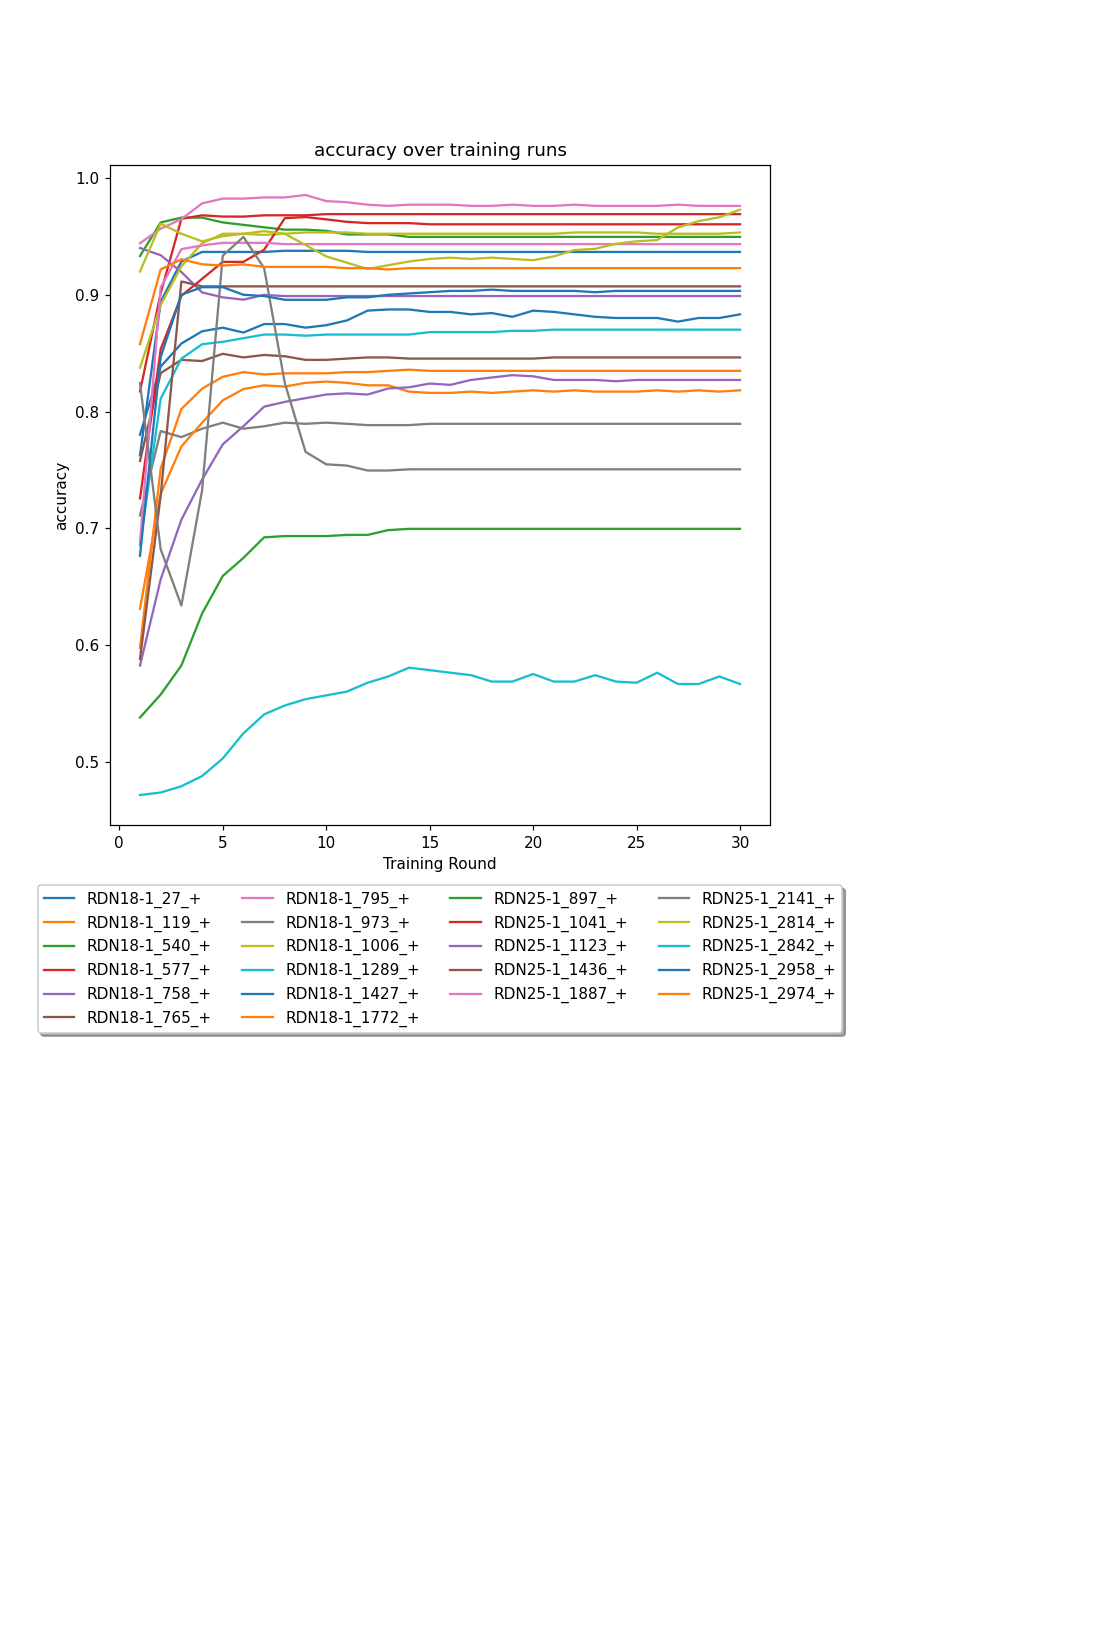

<IPython.core.display.Javascript object>


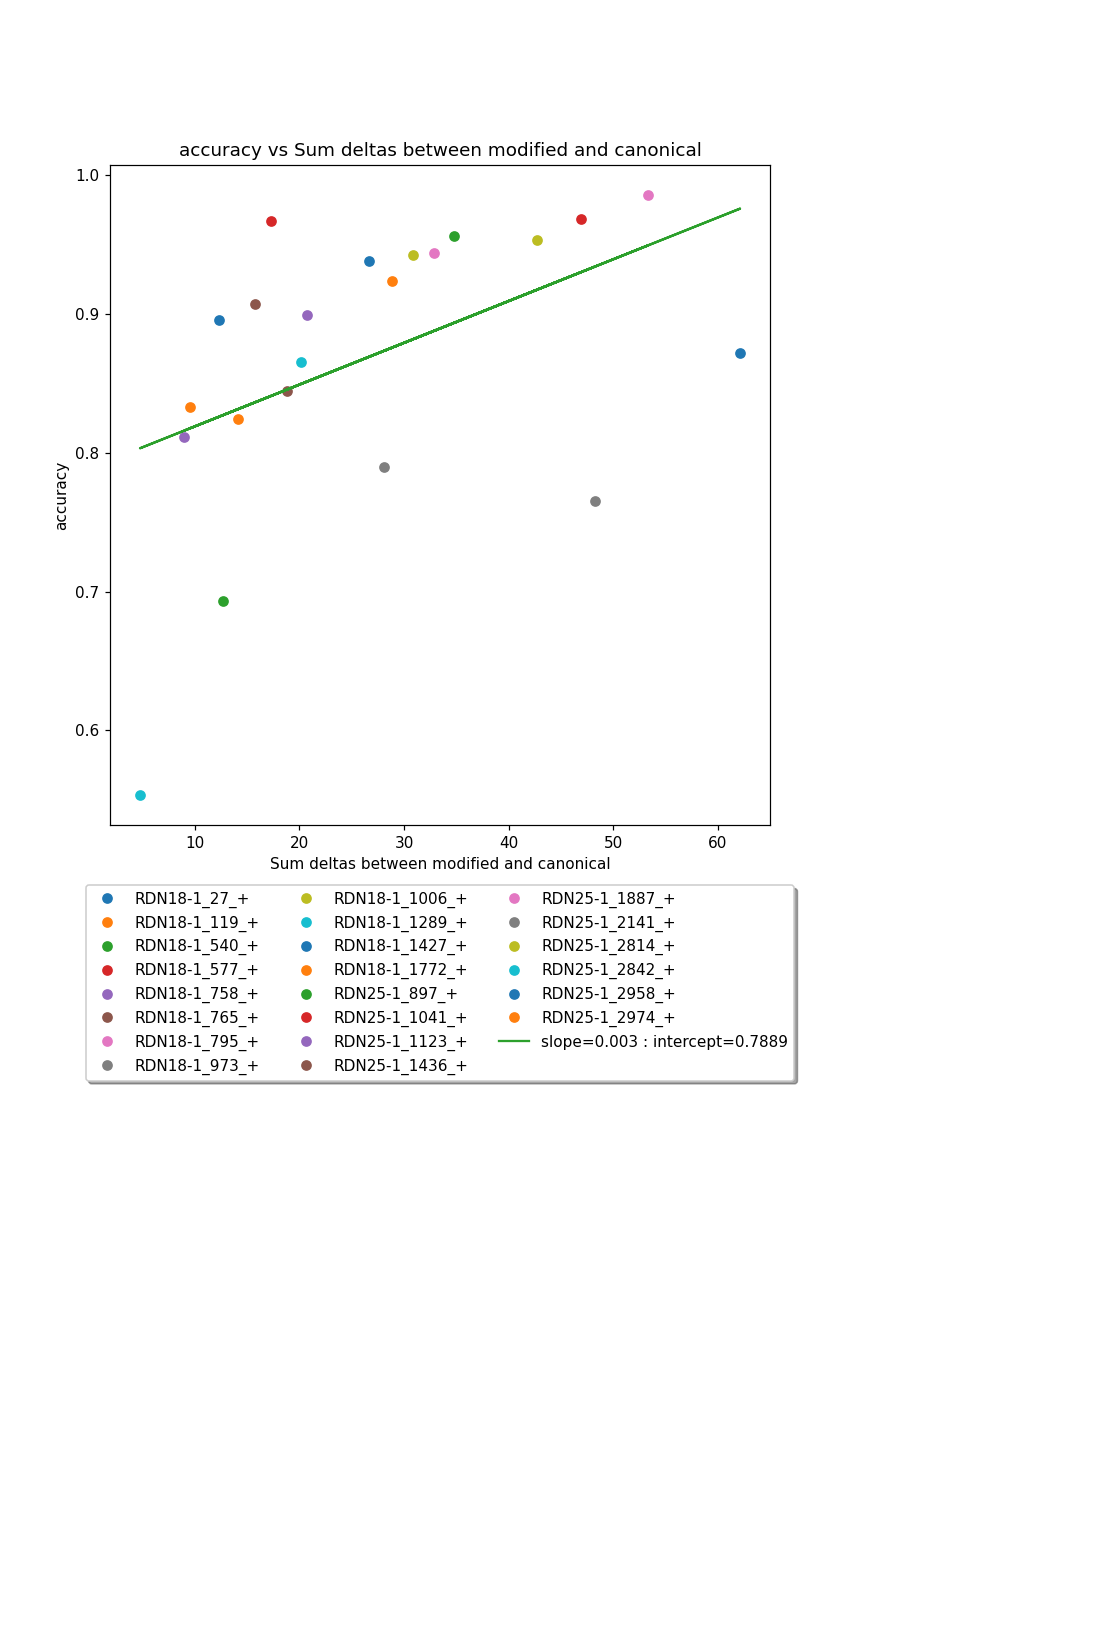

In [130]:
%matplotlib notebook
# train_500_test_500_prob_0.5_em_iterations_30
key="accuracy"
dir_path = "/Volumes/gdrive/rrna_kube_testing/supervised/probability_sweep/train_500_test_500_prob_0.5_em_iterations_30/testing_accuracy_csvs"
model_dir = "/Volumes/gdrive/rrna_kube_testing/supervised/probability_sweep/train_500_test_500_prob_0.5_em_iterations_30/training_models"
model_n = 29
p, k = plot_accuracy_vs_delta_and_accuracy_over_time(dir_path, model_dir, model_n, high_percent=100, low_percent=90, low_delta=6, high_delta=np.inf, key=key, max_delta=False)  


<IPython.core.display.Javascript object>


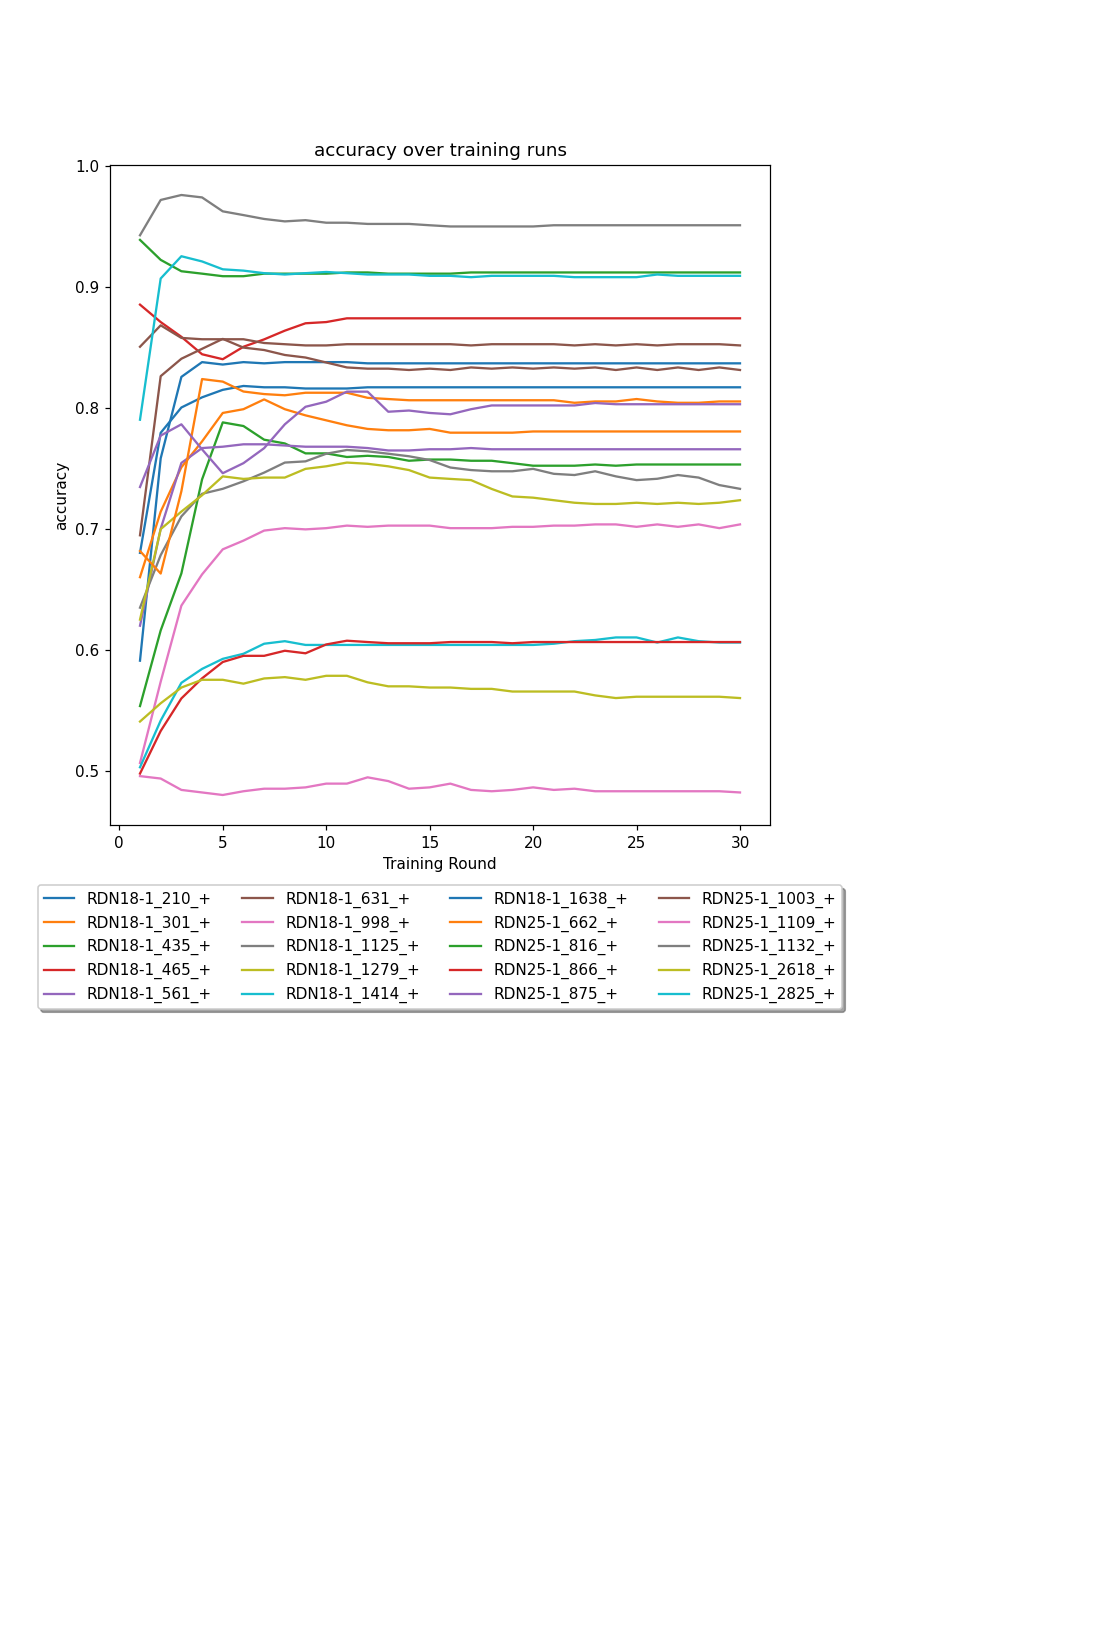

<IPython.core.display.Javascript object>


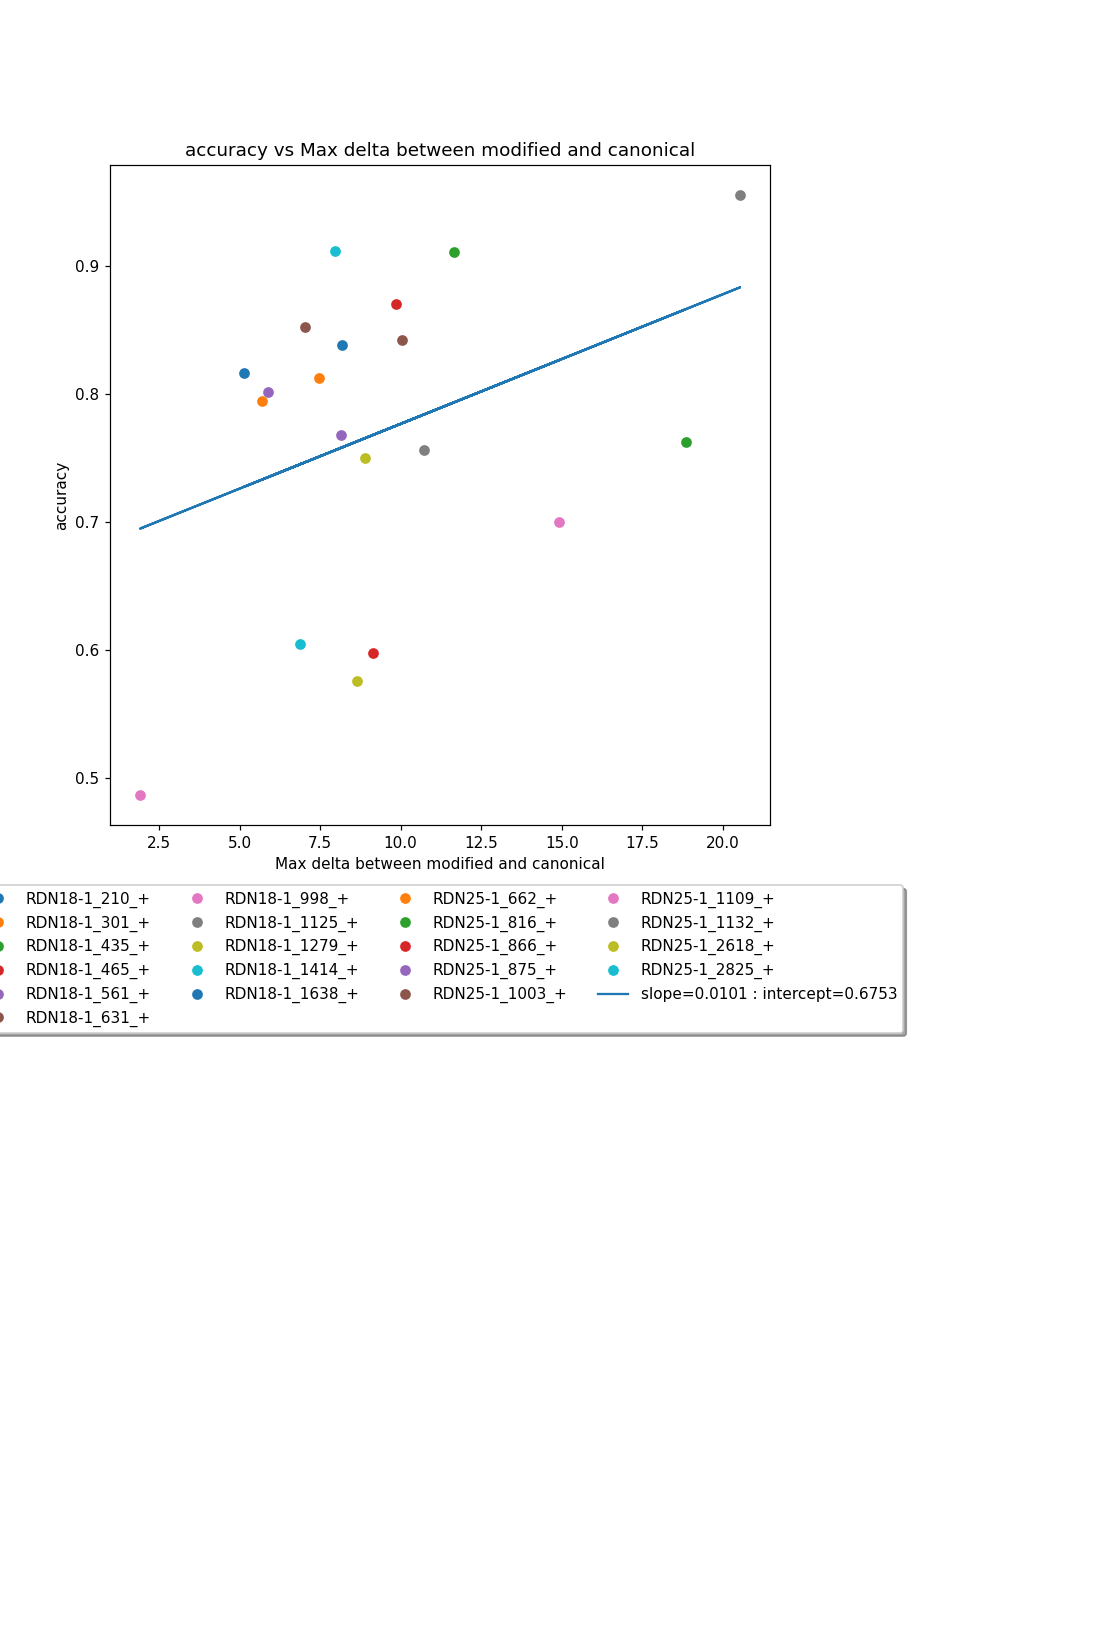

In [125]:
p, k = plot_accuracy_vs_delta_and_accuracy_over_time(dir_path, model_dir, model_n, high_percent=90, low_percent=0, low_delta=6, high_delta=np.inf, key=key, max_delta=True)  


<IPython.core.display.Javascript object>


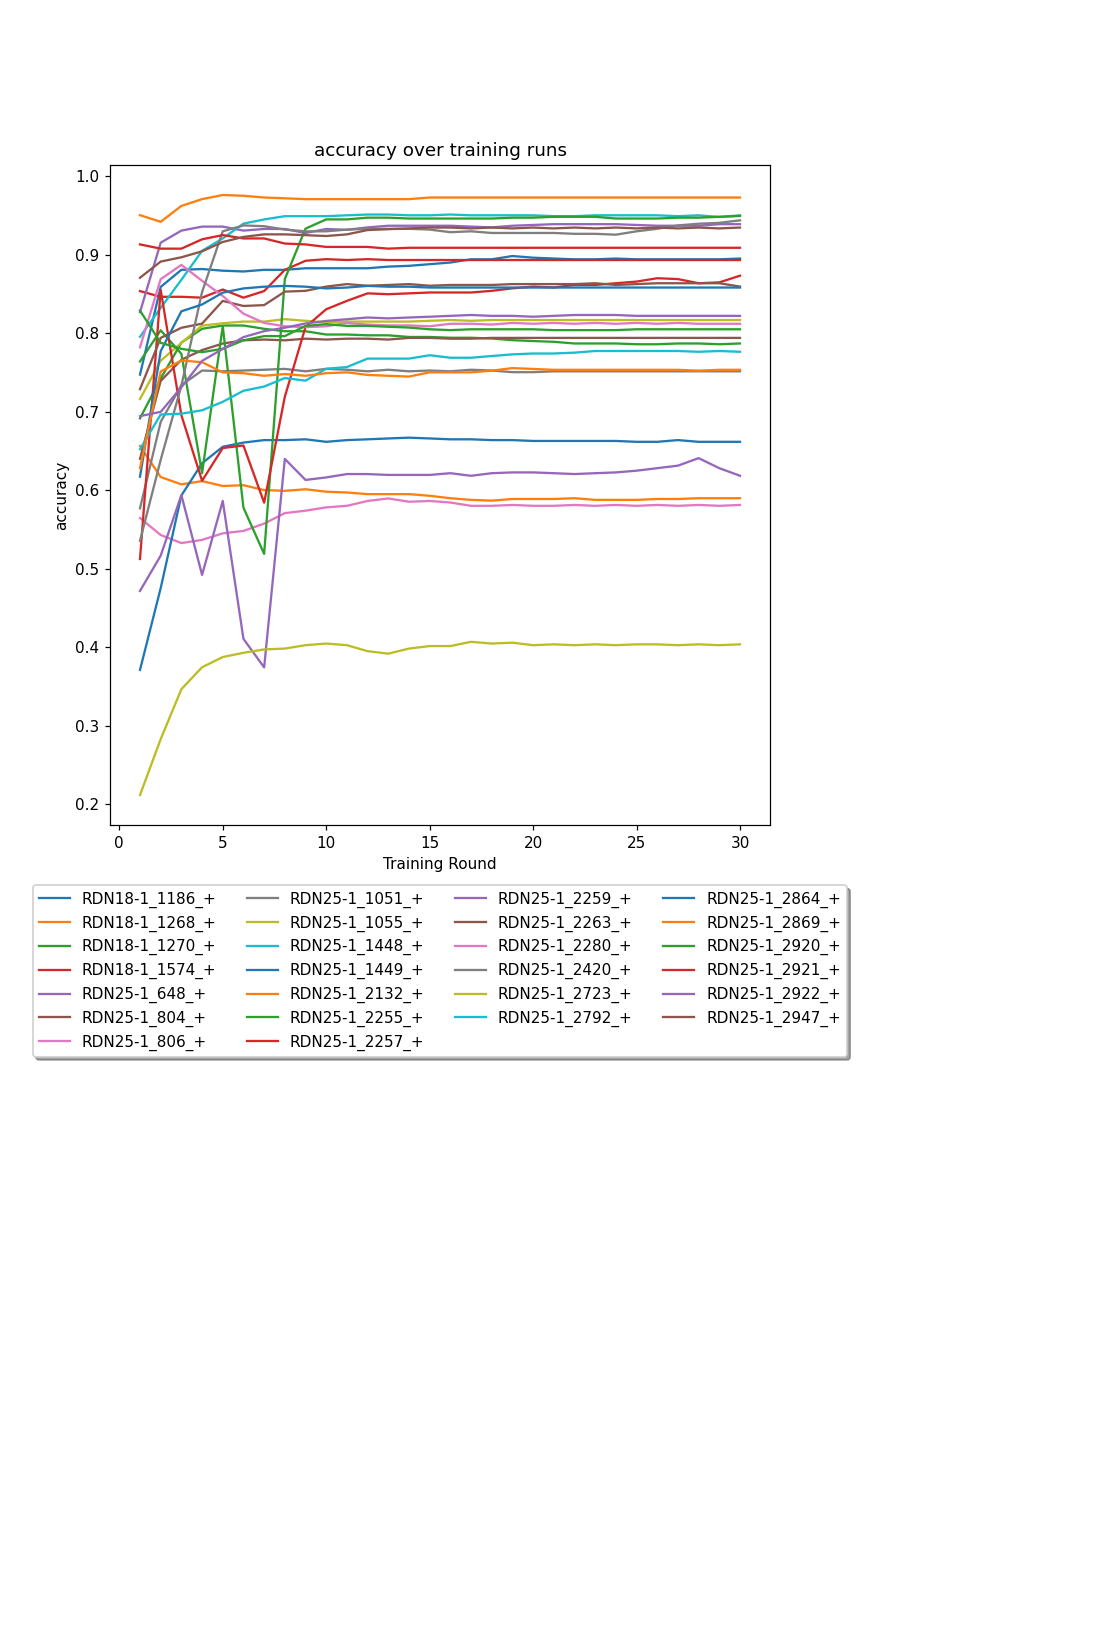

<IPython.core.display.Javascript object>


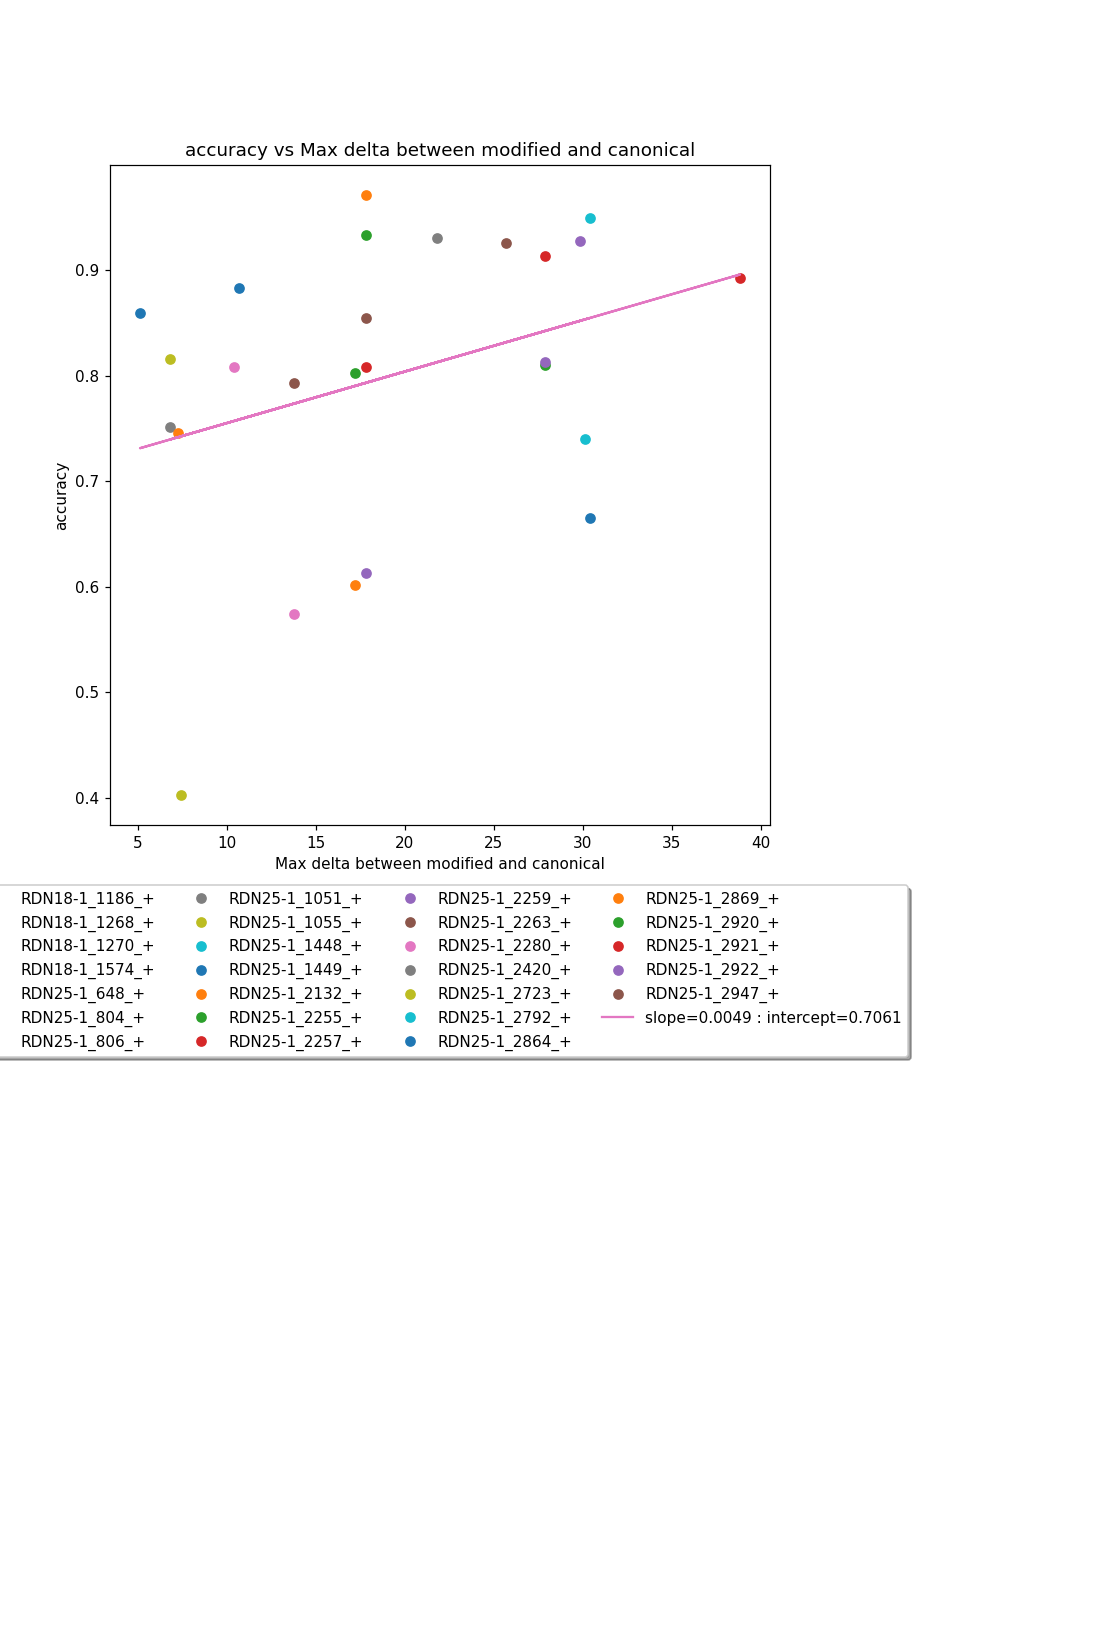

In [120]:
p, k = plot_accuracy_vs_delta_and_accuracy_over_time(dir_path, model_dir, model_n, high_percent=100, low_percent=94, low_delta=0, high_delta=6, key=key, max_delta=True)  
